### Introduction
Stock pool: All A shares in Chinese Stock Market     
Period: Weekly data during 2000-2021     
Database: CSMAR (国泰安数据库)     
Choosen Industries: 房地产开发（208），化学制剂（108），环保工程及服务（95），计算机设备（97），其他化学制品（163），其他专用机械（198），汽车零部件（191），软件开发（224），医疗器械（105），综合（169），IT服务（160）

### Outline
1. Data cleaning    
2. Investigate the lead-lag effect in intra-industries perspective   
3. Result I: Small firms have higher average return
4. Result II: Autocorrelation coefficient declines with size
5. VAR Test: Cross autocorrelations between lagged returns on big firms and current returns on small firms is greater than that between current returns on big firms and lagged returns on big firms

### Industry focus
In this empirical study, the exploitation of real estate industry is chosen as focus.

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
indclas = pd.read_csv('STK_INDUSTRYCLASS.csv')
# indcount = indclas[['Symbol','IndustryCode']].groupby(['IndustryCode']).apply(lambda x:(x['IndustryCode'].count()))

In [2]:
# merge tables
trdweek = pd.read_csv('TRD_Week.csv')
trdweek['Time'] = trdweek['Year']*100+trdweek['Week']

df = pd.merge(trdweek,indclas, on='Symbol',how='left')
df.dropna()

# Change the industry name here to see other results
df1 = df[df['IndustryName']=='房地产开发']
df1.head()

,Symbol,Trdwnt,Wsmvosd,Wsmvttl,Wretnd,Year,Week,Time,InstitutionID,IndustryClassificationName,ImplementDate,IndustryName
0,2,1991-05,406280.0,598489.62,NaN,1991,5,199105,101775,申银万国行业分类2014修订版,1991/1/29,房地产开发
1,2,1991-06,418320.0,616225.70,0.029635,1991,6,199106,101775,申银万国行业分类2014修订版,1991/1/29,房地产开发
2,2,1991-07,427000.0,629012.18,0.020750,1991,7,199107,101775,申银万国行业分类2014修订版,1991/1/29,房地产开发
3,2,1991-08,429240.0,632311.91,0.005246,1991,8,199108,101775,申银万国行业分类2014修订版,1991/1/29,房地产开发
4,2,1991-09,420280.0,619112.97,-0.020874,1991,9,199109,101775,申银万国行业分类2014修订版,1991/1/29,房地产开发


In [3]:
# Verify the first conclusion: 
# Small firms have higher average return
difference = []
for i in range(10,31): # Year--Range (2010-2021)
    df2 = df1[df1['Year']==1991+i]
    AvgMarket = DataFrame(df2[['Symbol','Wsmvosd','Year']].groupby(['Symbol','Year']).apply(lambda x:(x['Wsmvosd'].mean())).reset_index())
    cols = ['Symbol','Year','AvgMarket']
    AvgMarket.columns = cols
    AvgReturn = DataFrame(df2[['Symbol','Wretnd','Year']].groupby(['Symbol','Year']).apply(lambda x:(x['Wretnd'].mean())).reset_index())
    cols = ['Symbol','Year','AvgReturn']
    AvgReturn.columns = cols
    df3 = pd.merge(AvgMarket, AvgReturn, on='Symbol', how='left')
    # df3.sort_values(by='AvgMarket',ascending=False,inplace=True)
    highgroup_ret = df3['AvgReturn'][df3.AvgMarket.rank(pct=True)>=0.7].mean()
    lowgroup_ret = df3['AvgReturn'][df3.AvgMarket.rank(pct=True)<=0.3].mean()
    difference.append(highgroup_ret-lowgroup_ret)
difference

[-0.00010113337585100114,
 -9.942029979823075e-06,
 0.0042556727965385385,
 0.000954798854968829,
 -0.0009765601017994712,
 0.014011337378988539,
 -0.021278024874936387,
 -0.01052593256094942,
 -0.007875414081269055,
 -0.007250006414041653,
 -0.012300198994262164,
 0.0014641277203604735,
 -0.0030096001389214744,
 0.0024930183922161255,
 -0.00936223596639598,
 -0.0037272537466162122,
 0.007425501485319193,
 0.004953318270766742,
 0.0030403324701590664,
 0.0030682553672347524,
 0.00719931222573445]

In [4]:
# Verify the second conclusion:
# Autocorrelation coefficient declines with size

def autocorrelation(x,lags):
	'''
	Calculate lags order autocorrelations
	Return lags value
	Series mean and variance constant
	'''
	n = len(x)
	x = np.array(x)
	variance = x.var()
	x = x-x.mean()
	result = np.correlate(x, x, mode = 'full')[-n+1:-n+lags+1]/\
		(variance*(np.arange(n-1,n-1-lags,-1)))
	return result

for i in range(10,31):
	df2 = df1[df1['Year']==1991+i]
	autocorr = DataFrame(df2[['Symbol','Year','Wretnd']].groupby(['Symbol','Year']).apply(lambda x:(autocorrelation(x['Wretnd'],1))).reset_index())
	cols = ['Symbol','Year','AutoCorr']
	autocorr.columns = cols
	autocorr = pd.merge(autocorr, AvgMarket, on='Symbol', how='left')
	autocorr.sort_values(by='AvgMarket',ascending=True,inplace=True)
autocorr.head()

<ipython-input-4-40f65c37d4c8>:14: RuntimeWarning: invalid value encountered in true_divide
  result = np.correlate(x, x, mode = 'full')[-n+1:-n+lags+1]/\


,Symbol,Year_x,AutoCorr,Year_y,AvgMarket
145,600634,2021,[0.6663887222671467],2021,199038.802857
118,600247,2021,[-0.508237199867358],2021,299012.472500
57,760,2021,[0.6243896425330375],2021,325352.294286
155,600687,2021,[-0.04131367413278824],2021,455919.061250
90,300917,2021,[-0.15412032464114456],2021,844845.112500


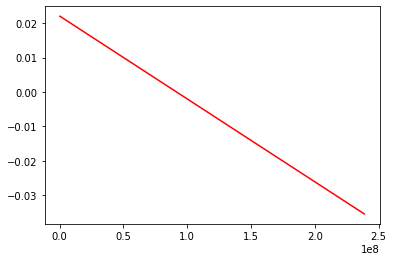

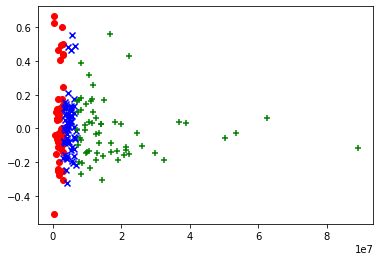

In [5]:
# Plot the results
from sklearn.linear_model import LinearRegression

d1 = autocorr['AvgMarket'].__array__().reshape(-1,1)
d2 = autocorr['AutoCorr'].__array__().reshape(-1,1)

reg=LinearRegression()
reg.fit(d1,d2)
plt.plot(d1,reg.predict(d1),color="red")
plt.show()
plt.scatter(d1[:60], d2[:60], color='red', marker='o')
plt.scatter(d1[60:120], d2[60:120], color='blue', marker='x')
plt.scatter(d1[120:180], d2[120:180], color='green', marker='+')
plt.show()
# sns.regplot(x=d1, y=d2, marker='+', label='Distribution Dots', truncate=False, line_kws={'label': 'Regression Line'})

### Verify the third result: (VAR Test)
Cross autocorrelation coefficient between lagged returns on big firms and current returns on small firms is greater than that between current returns on big firms and lagged returns on big firms.

In [6]:
# Derive the main table
highcols = ['HighSymbol', 'HighgroupRet','Time']
lowcols = ['LowSymbol', 'LowgroupRet']
# high = DataFrame(columns=highcols)
# low = DataFrame(columns=lowcols)
maincols = ['HighSymbol', 'HighgroupRet', 'Time', 'LowSymbol', 'LowgroupRet']
maindf = DataFrame(columns=maincols)
for i in range(2000):     # 2000 iterations
    df2 = df1[df1['Time']==200002+i]
    highgroup = DataFrame(df2['Symbol'][df2.Wsmvosd.rank(pct=True)>=0.7])
    merge1 = pd.merge(highgroup, df2[['Symbol','Wretnd','Time']], on='Symbol', how='left')
    merge1.columns = highcols
    # high = pd.merge(high, merge1, how='outer')

    lowgroup = DataFrame(df2['Symbol'][df2.Wsmvosd.rank(pct=True)<=0.3])
    merge2 = pd.merge(lowgroup, df2[['Symbol','Wretnd']], on='Symbol', how='left')    
    merge2.columns = lowcols
    # low = pd.merge(low, merge2, how='outer')
    result = pd.concat([merge1,merge2],axis=1).dropna()
    maindf = pd.merge(maindf, result, how='outer')

# Datetime transformation
maindf['Time'] = maindf['Time'].astype(int)
maindf['LastDayWeek'] = pd.to_datetime((maindf['Time']-1).astype(str) + "6", format="%Y%U%w")
maindf = maindf[['LastDayWeek','HighgroupRet','LowgroupRet']]
maindf.to_csv('VARtest.csv', index=False)
maindf.tail()

,LastDayWeek,HighgroupRet,LowgroupRet
60367,2020-01-04,0.038095,0.002020
60368,2020-01-04,-0.008889,-0.029720
60369,2020-01-04,0.003135,0.076433
60370,2020-01-04,-0.010589,0.027106
60371,2020-01-04,0.003049,0.034483


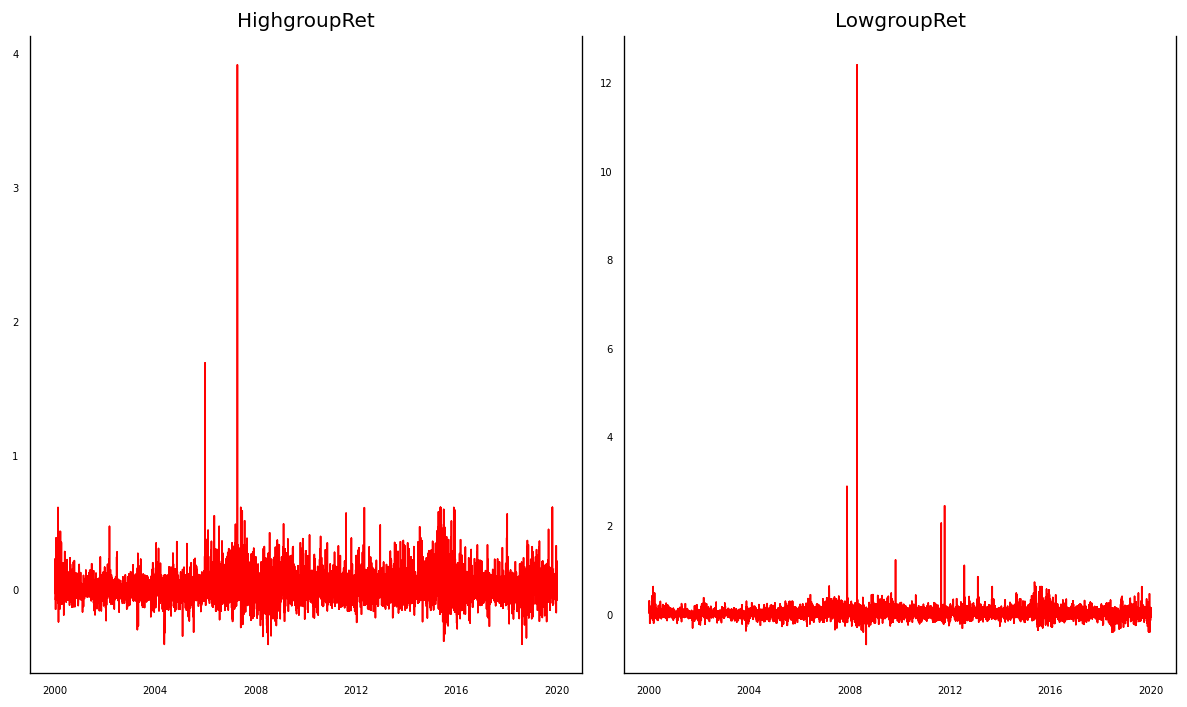

In [7]:
# Visualize the Time Series
# df = maindf[['LastDayWeek','HighgroupRet','LowgroupRet']]

df = pd.read_csv('VARtest.csv', parse_dates=['LastDayWeek'], index_col='LastDayWeek')
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data=df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    #decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
    plt.tight_layout()


In [8]:
# Testing Causation using Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,HighgroupRet_x,LowgroupRet_x
HighgroupRet_y,1.0,0.0
LowgroupRet_y,0.0,1.0


In [9]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)
def adjust(val, length= 6): return str(val).ljust(length)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
HighgroupRet ::  8577.96   > 12.3212   =>   True
LowgroupRet ::  1949.12   > 4.1296    =>   True


### Check for stationarity
Here, Augmented Dickey-Fuller Test (ADF Test) is implemented

In [10]:
nobs = 20      # fit the model and forecast the next 20 observations
df_train, df_test = df[0:-nobs], df[-nobs:]

# # Check size
# print(df_train.shape)  # (60352, 2)
# print(df_test.shape)  # (20, 2)
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "HighgroupRet" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.047
 No. Lags Chosen       = 60
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "LowgroupRet" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.0041
 No. Lags Chosen       = 55
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [11]:
# Select the order (P) of the VAR model
#! Use alternative method: VAR Order Selection
model = VAR(df_train)
for i in range(1, 15):
    result = model.fit(i)
    print('Lag Order =',i)
    print('AIC: ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC:  -10.607099461439477
BIC :  -10.606203907152416
FPE :  2.4739745910634533e-05
HQIC:  -10.606821365068011 



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order = 2
AIC:  -10.720060865878866
BIC :  -10.718568253413824
FPE :  2.2097173227529528e-05
HQIC:  -10.719597364745171 

Lag Order = 3
AIC:  -10.759181439700912
BIC :  -10.757091751467646
FPE :  2.1249409744716935e-05
HQIC:  -10.758532528059664 

Lag Order = 4
AIC:  -10.770994498456293
BIC :  -10.768307716863742
FPE :  2.0999866057995742e-05
HQIC:  -10.770160170561896 

Lag Order = 5
AIC:  -10.781724190528475
BIC :  -10.778440297984755
FPE :  2.077574846822392e-05
HQIC:  -10.780704440635054 

Lag Order = 6
AIC:  -10.79113164022951
BIC :  -10.78725061914192
FPE :  2.0581218111550317e-05
HQIC:  -10.78992646259092 

Lag Order = 7
AIC:  -10.798345075008148
BIC :  -10.793866907783167
FPE :  2.0433291009865876e-05
HQIC:  -10.796954463877967 

Lag Order = 8
AIC:  -10.803132643904215
BIC :  -10.798057312947499
FPE :  2.0335699022162708e-05
HQIC:  -10.801556593535745 

Lag Order = 9
AIC:  -10.80809938819137
BIC :  -10.802426875907754
FPE :  2.023494721680218e-05
HQIC:  -10.806337892837638 

In [12]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-10.19,-10.19,3.748e-05,-10.19
1,-10.61,-10.61,2.474e-05,-10.61
2,-10.72,-10.72,2.210e-05,-10.72
3,-10.76,-10.76,2.125e-05,-10.76
4,-10.77,-10.77,2.100e-05,-10.77
5,-10.78,-10.78,2.078e-05,-10.78
6,-10.79,-10.79,2.058e-05,-10.79
7,-10.80,-10.79,2.043e-05,-10.80
8,-10.80,-10.80,2.034e-05,-10.80
9,-10.81,-10.80,2.024e-05,-10.81


Here, we follow the strategy mentioned in the original paper, that is, we use lag-4 to further proceed the model fitting.

In [13]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Jun, 2022
Time:                     15:41:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.7683
Nobs:                     60348.0    HQIC:                  -10.7702
Log likelihood:           153762.    FPE:                2.09999e-05
AIC:                     -10.7710    Det(Omega_mle):     2.09936e-05
--------------------------------------------------------------------
Results for equation HighgroupRet
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.001685         0.000236            7.153           0.000
L1.HighgroupRet         0.253255         0.004065           62.296           0.000
L1.LowgroupRet          0.052477         0.00

### Serial Correlation - Residuals - Durbin Watson Statistic
Serial correlation of residuals is used to check if there is any leftover pattern in the residuals.     
Note:      
    A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [14]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

HighgroupRet : 2.01
LowgroupRet : 2.01


There is no significant serial correlation --> Can further proceed the forcast.